In [272]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.tree import export_graphviz
from IPython.display import Image, display
import pydotplus
import plotly.graph_objects as go
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool, cv
import pandas as pd
import numpy as np

In [273]:
random_state = 42

beer_df = pd.read_csv('../scrapped_data/beer.csv', thousands=",").iloc[:,1:]
brewery_df = pd.read_csv('../scrapped_data/brewery.csv', thousands=",").iloc[:,1:]
comment_df = pd.read_csv('../scrapped_data/comment.csv', thousands=",").iloc[:,1:]
location_df = pd.read_csv('../scrapped_data/location.csv', thousands=",").iloc[:,1:]
style_df = pd.read_csv('../scrapped_data/style.csv', thousands=",").iloc[:,1:]

In [274]:
merged_df = pd.merge(
    left=beer_df,
    right=brewery_df,
    left_on="brewery_id",
    right_on="id",
    how="left",
    suffixes=("", "_brewery"),
)
merged_df = pd.merge(
    left=merged_df,
    right=location_df,
    left_on="location_id",
    right_on="id",
    how="left",
    suffixes=("", "_location"),
)
merged_df = pd.merge(
    left=merged_df,
    right=style_df,
    left_on="style_id",
    right_on="id",
    how="left",
    suffixes=("", "_style"),
)

merged_df = merged_df[["avg", 'score', "pdev", "country", 'count_reviews', 'count_ratings', 'avg_score', 'abv_from', 'abv_to', 'glassware', 'ibu_from', 'ibu_to']]
merged_df = merged_df.dropna()

In [275]:
y = merged_df['score']
X = merged_df.drop(columns=['score'])
label_encoders = {}

for feature in ["pdev"]:
    label_encoder = LabelEncoder()
    X[feature] = label_encoder.fit_transform(X[feature])
    label_encoders.update({feature: label_encoder})

for feature in ["country", "glassware"]:
    label_encoder = OneHotEncoder(sparse=False)
    X_encoded = label_encoder.fit_transform(X[[feature]])
    encoded_df = pd.DataFrame(X_encoded, columns=label_encoder.get_feature_names_out([feature]))
    X = pd.concat([X.drop(columns=[feature]).reset_index(), encoded_df.reset_index()], axis=1)
    label_encoders.update({feature: label_encoder})
    
X = X.drop(columns=['index', 'level_0'])

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [276]:
model = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_split=2, min_samples_leaf=1, random_state=random_state)

kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)

f1_scorer = make_scorer(f1_score, average='weighted')
cv_results = cross_val_score(model, X, y, cv=kfold, scoring=f1_scorer)

print(f'Cross-Validation Results: {cv_results}')
print(f'Mean F1: {cv_results.mean()}')
print(f'Standard Deviation: {cv_results.std()}')

Cross-Validation Results: [0.86418565 0.82179033 0.7854985  0.88412253 0.88356486]
Mean F1: 0.847832375489924
Standard Deviation: 0.03853547752681078


In [277]:
model = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_split=2, min_samples_leaf=1, random_state=random_state)

model.fit(X, y)

RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)

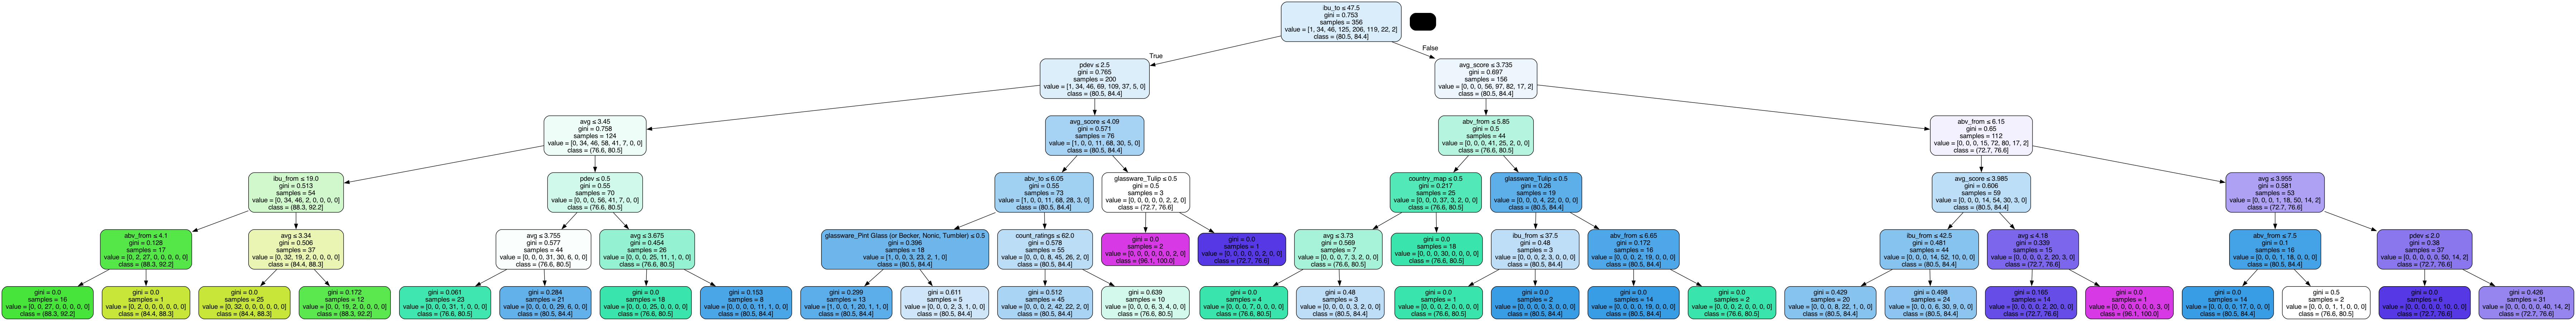

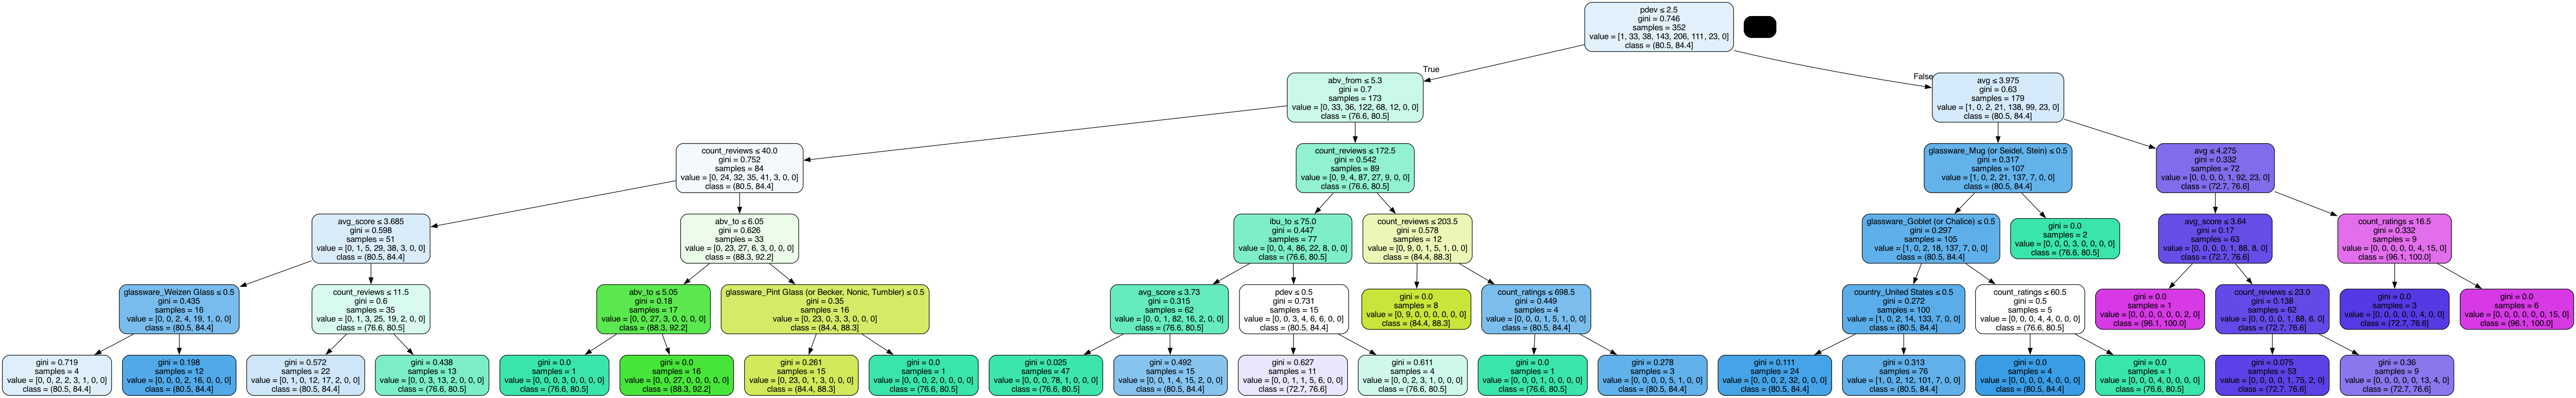

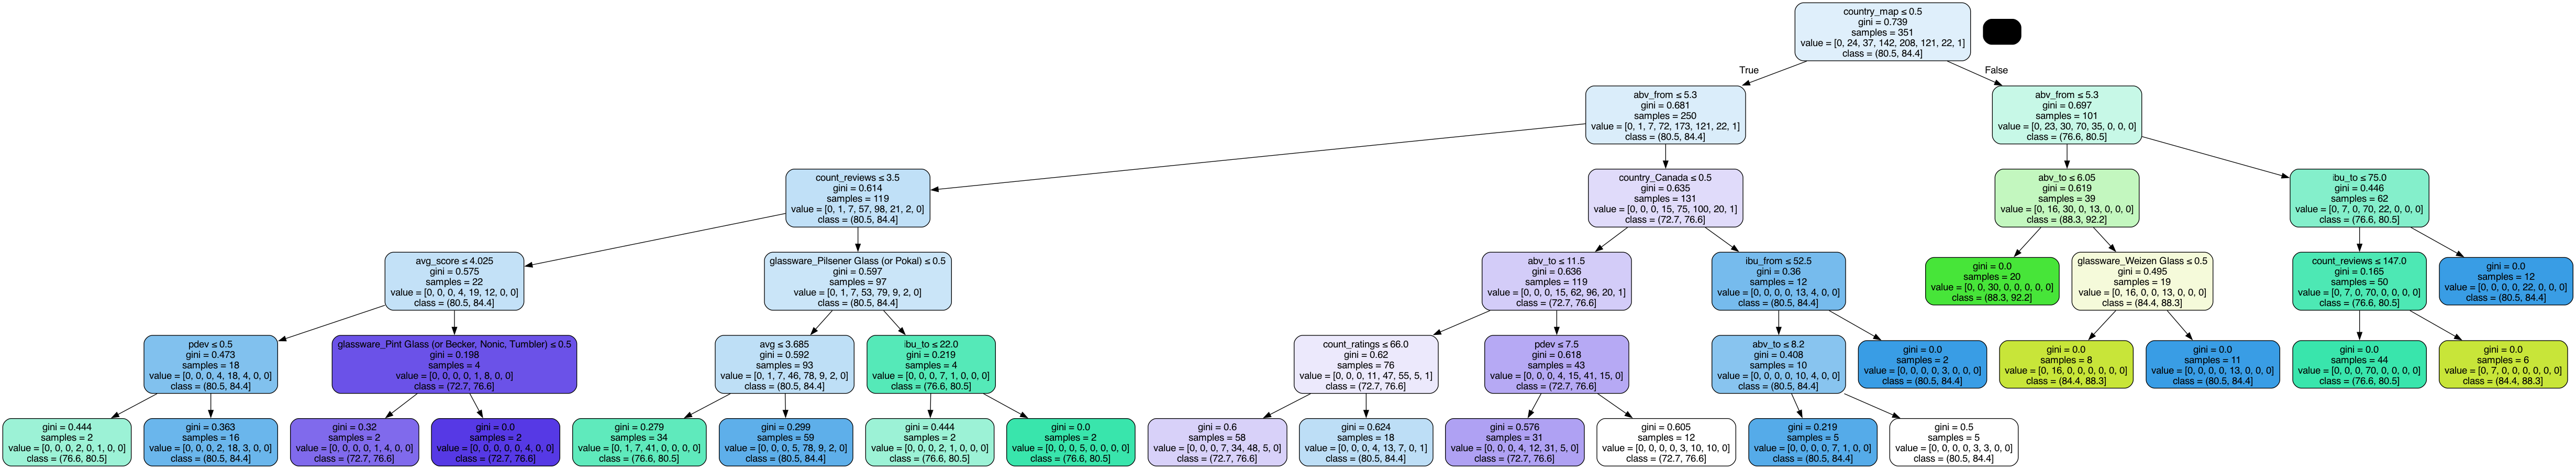

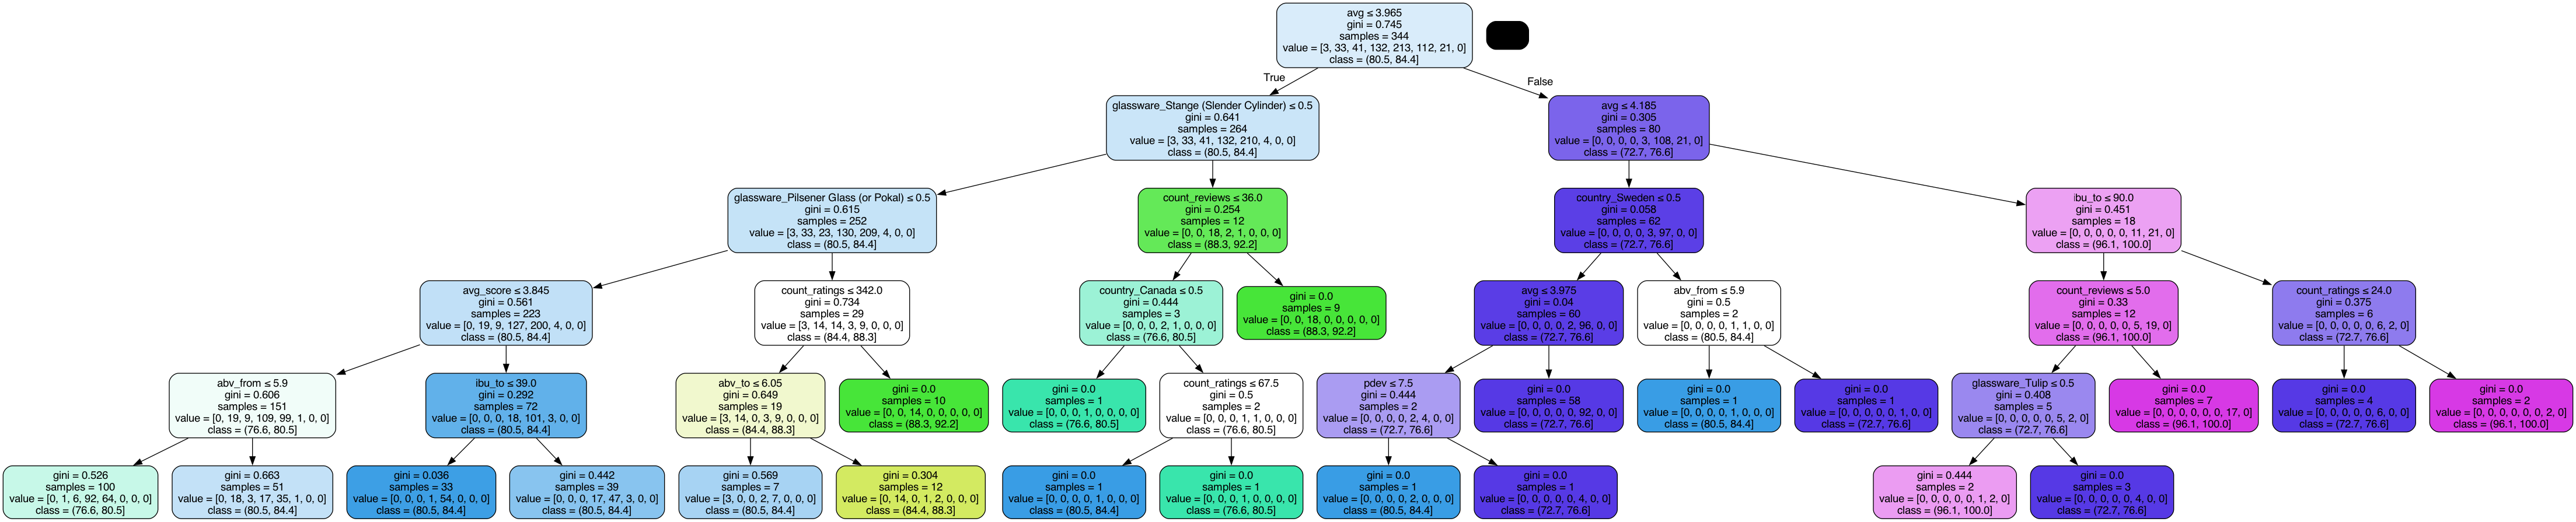

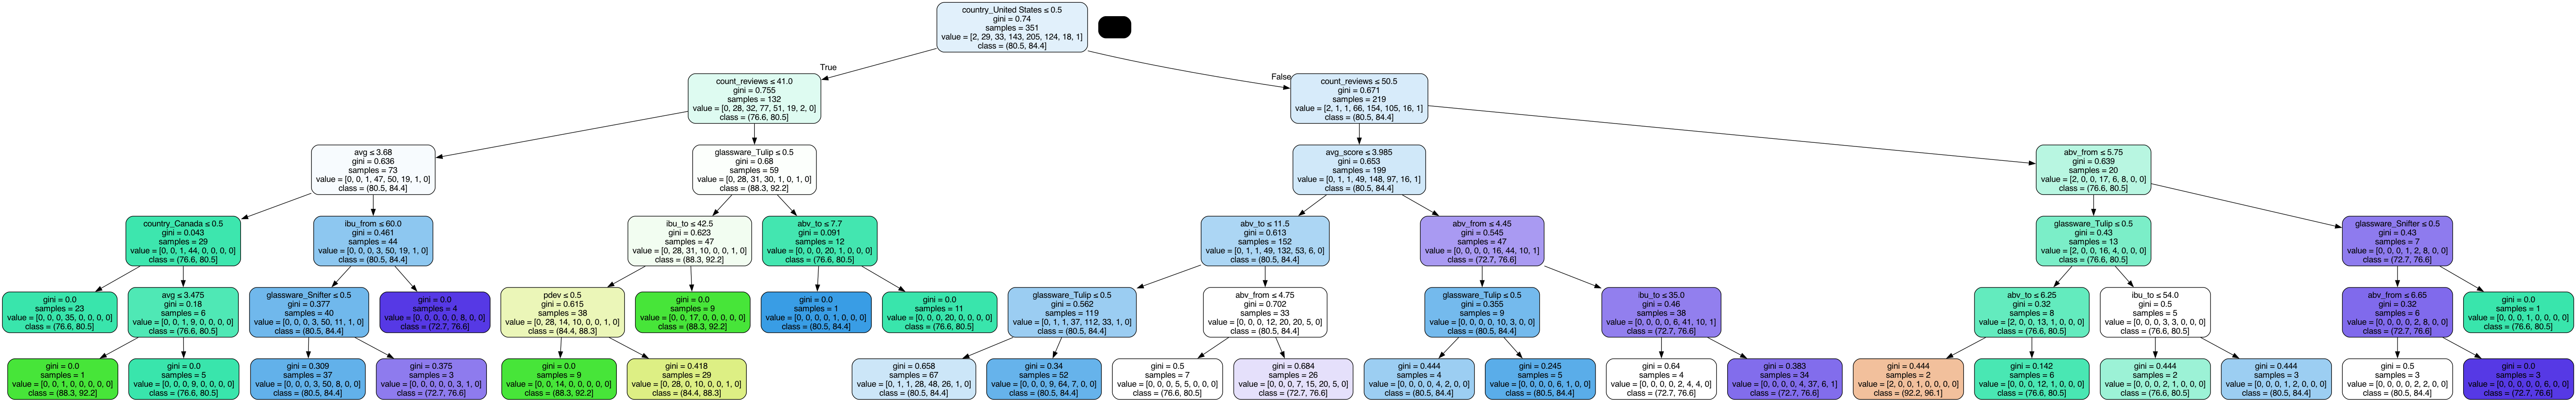

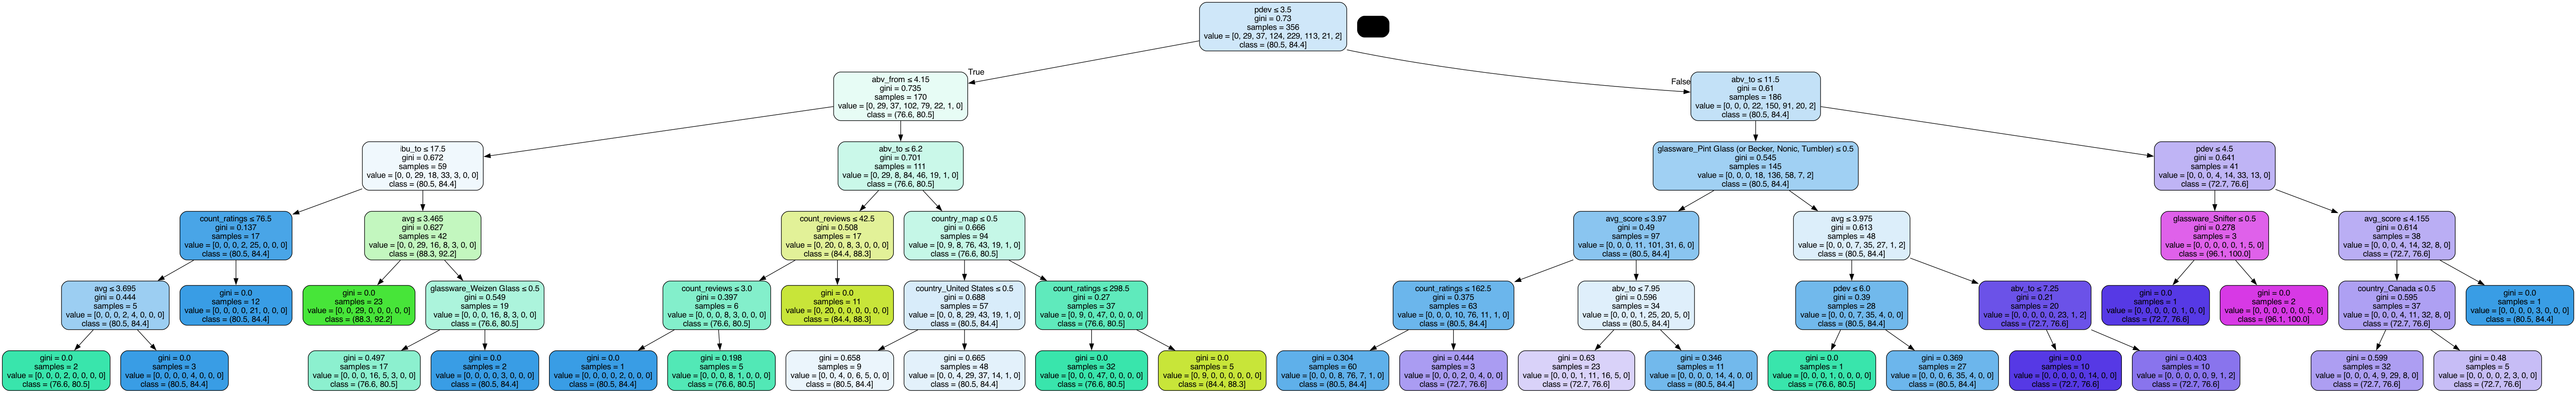

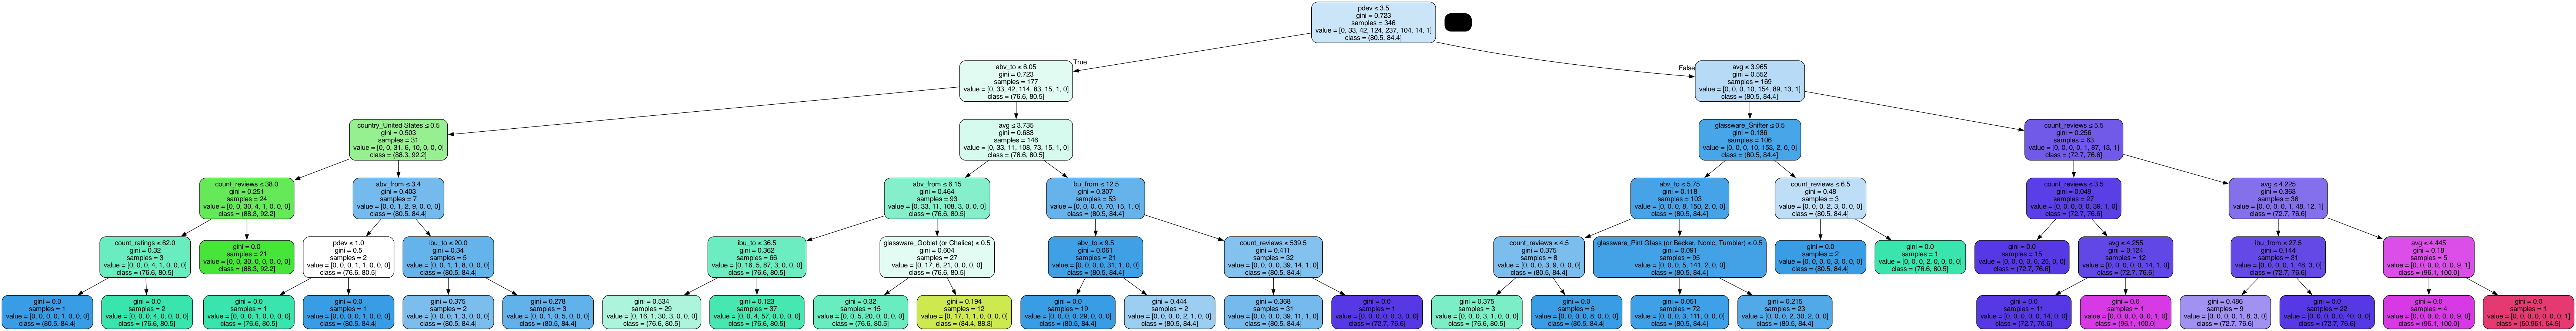

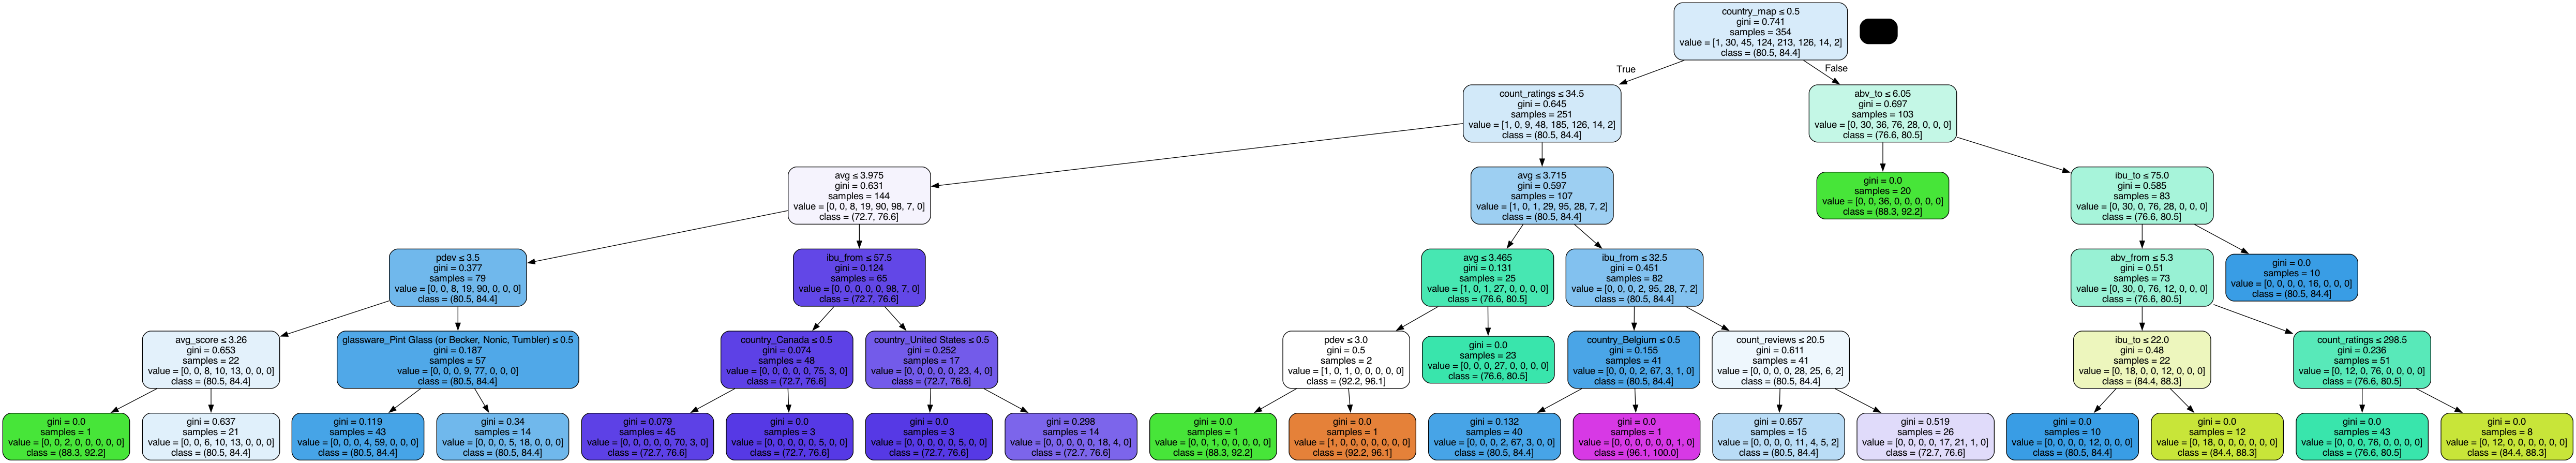

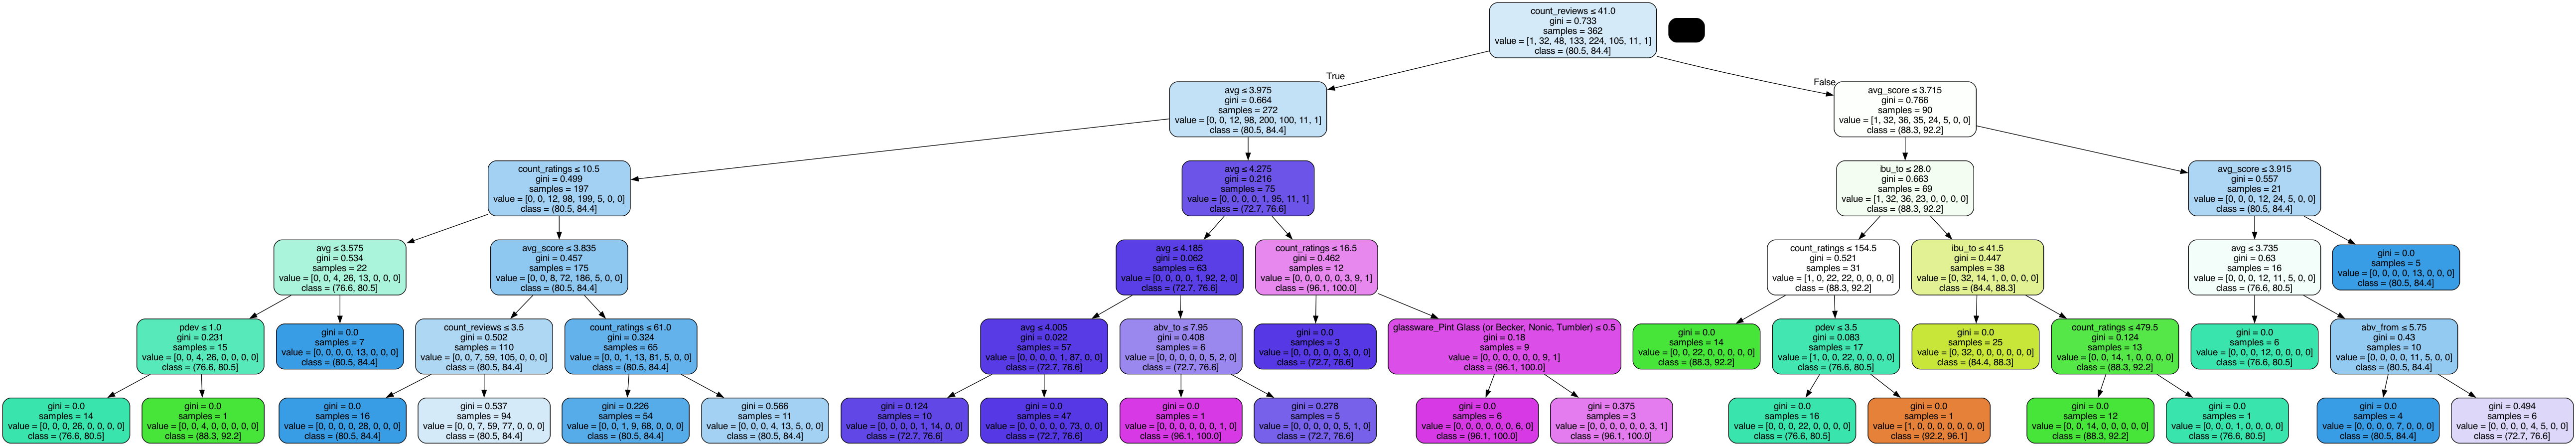

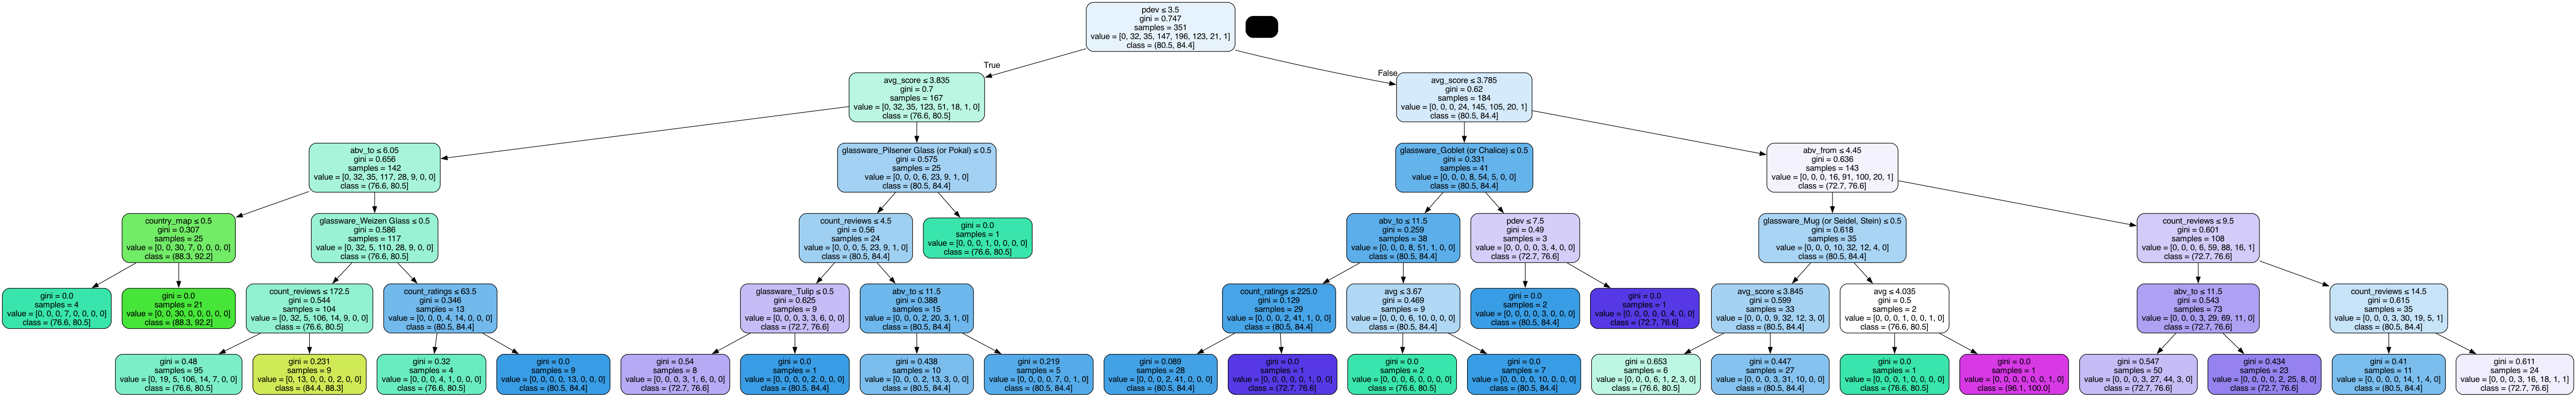

In [278]:
for i, tree in enumerate(model.estimators_):
    # Export the tree as a Graphviz representation
    dot_data = export_graphviz(tree, out_file=None, feature_names=list(X.columns), class_names=list(y.unique()), filled=True, rounded=True, special_characters=True)
    
    # Convert the Graphviz representation to a PNG image
    graph = pydotplus.graph_from_dot_data(dot_data)
    graph.set_graph_defaults(fontname='Arial')
    graph.write_png(f'../predict_data/tree_{i}.png')

    # Load the PNG image and display it using Plotly
    img_path = f'../predict_data/tree_{i}.png'
    img = Image(filename=img_path)
    display(img)

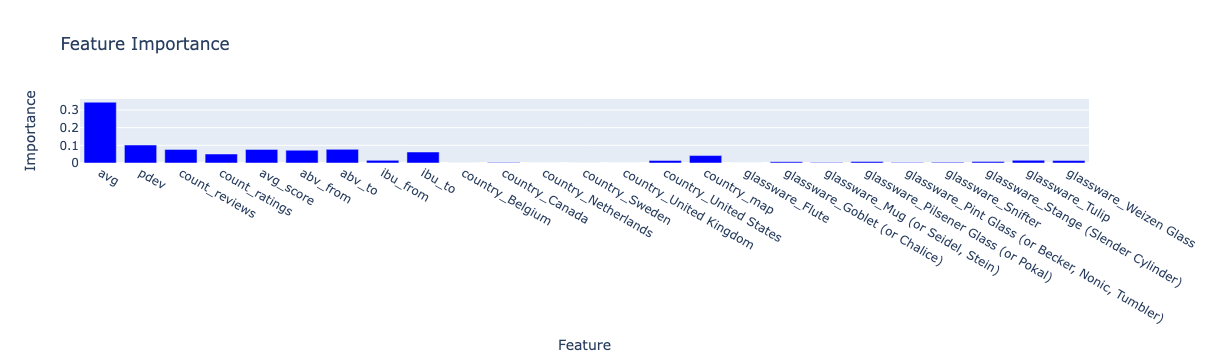

In [279]:
importances = model.feature_importances_

# Create a trace for the bar chart
trace = go.Bar(x=X.columns, y=importances, marker=dict(color='blue'))

# Create the layout for the chart
layout = go.Layout(title='Feature Importance', xaxis=dict(title='Feature'), yaxis=dict(title='Importance'))

# Create the figure
fig = go.Figure(data=[trace], layout=layout)

# Show the plot
fig.show()

In [281]:
import gradio as gr
import random
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import shap


matplotlib.use("Agg")
explainer = shap.TreeExplainer(model)

def predict(*args):
    df = pd.DataFrame([args], columns=["avg", "pdev", "country", 'count_reviews', 'count_ratings', 'avg_score', 'abv_from', 'abv_to', 'glassware', 'ibu_from', 'ibu_to'])
    for feature in ["country", "glassware"]:
        label_encoder = label_encoders[feature]
        df_encoded = label_encoder.transform(df[[feature]])
        encoded_df = pd.DataFrame(df_encoded, columns=label_encoder.get_feature_names_out([feature]))
        df = pd.concat([df.drop(columns=[feature]).reset_index(), encoded_df.reset_index()], axis=1)
        
    df = df.drop(columns=['index', 'level_0'])
    
    for feature in ["pdev"]:
        df[feature] = label_encoders[feature].transform(df[feature])
    pos_pred = model.predict(df)
    return pos_pred[0]


unique_country = sorted(merged_df["country"].unique())
unique_glassware = sorted(merged_df["glassware"].unique())
unique_pdev = sorted(label_encoders["pdev"].inverse_transform(X["pdev"].unique()))
avg = [X["avg"].min().item(), X["avg"].max().item()]
count_reviews = [X["count_reviews"].min().item(), X["count_reviews"].max().item()]
count_ratings = [X["count_ratings"].min().item(), X["count_ratings"].max().item()]
avg_score = [X["avg_score"].min().item(), X["avg_score"].max().item()]
abv_from = [X["abv_from"].min().item(), X["abv_from"].max().item()]
abv_to = [X["abv_to"].min().item(), X["abv_to"].max().item()]
ibu_to = [X["ibu_to"].min().item(), X["ibu_to"].max().item()]
ibu_from = [X["ibu_from"].min().item(), X["ibu_from"].max().item()]


with gr.Blocks() as demo:
    gr.Markdown("""
    **Demo beer classification with Random Forest 💰**:  This demo uses an Random Forest classifier predicts beer score class.
    """)
    with gr.Row():
        with gr.Column():
            avg_input = gr.Slider(
                label="Avg reviews",
                minimum=avg[0],
                maximum=avg[1],
                step=0.1,
                randomize=True,
            )
            unique_pdev_input = gr.Dropdown(
                label="pdev",
                choices=unique_pdev,
                value=lambda: random.choice(unique_pdev),
            )
            unique_country_input = gr.Dropdown(
                label="Brewery country",
                choices=unique_country,
                value=lambda: random.choice(unique_country),
            )
            count_reviews_input = gr.Slider(
                label="Count reviews",
                minimum=count_reviews[0],
                maximum=count_reviews[1],
                step=1,
                randomize=True,
            )
            count_ratings_input = gr.Slider(
                label="Count ratings",
                minimum=count_ratings[0],
                maximum=count_ratings[1],
                step=1,
                randomize=True,
            )
            avg_score_input = gr.Slider(
                label="Average brewery score",
                minimum=avg_score[0],
                maximum=avg_score[1],
                step=0.1,
                randomize=True,
            )
            abv_from_input = gr.Slider(
                label="Abv from",
                minimum=abv_from[0],
                maximum=abv_from[1],
                step=0.1,
                randomize=True,
            )
            abv_to_input = gr.Slider(
                label="Abv to",
                minimum=abv_to[0],
                maximum=abv_to[1],
                step=0.1,
                randomize=True,
            )
            glassware_input = gr.Dropdown(
                label="Glassware",
                choices=unique_glassware,
                value=lambda: random.choice(unique_glassware),
            )
            ibu_from_input = gr.Slider(
                label="Ibu from",
                minimum=ibu_from[0],
                maximum=ibu_from[1],
                step=0.1,
                randomize=True,
            )
            ibu_to_input = gr.Slider(
                label="Ibu to",
                minimum=ibu_to[0],
                maximum=ibu_to[1],
                step=0.1,
                randomize=True,
            )
        with gr.Column():
            label = gr.Label()
            with gr.Row():
                predict_btn = gr.Button(value="Predict")
            predict_btn.click(
                predict,
                inputs=[
                    avg_input,
                    unique_pdev_input,
                    unique_country_input,
                    count_reviews_input,
                    count_ratings_input,
                    avg_score_input,
                    abv_from_input,
                    abv_to_input,
                    glassware_input,
                    ibu_from_input,
                    ibu_to_input,
                ],
                outputs=[label],
            )

demo.launch()

Running on local URL:  http://127.0.0.1:7901

To create a public link, set `share=True` in `launch()`.
